In [375]:
#Importing the libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import stats
from scipy.stats import t as t 
from scipy.optimize import curve_fit
from scipy.constants import *
from scipy.signal import find_peaks

from uncertainties import *
from uncertainties.umath import *

In [376]:
#Reading data

VA = pd.read_excel('data/VA.xlsx')
spec = pd.read_csv('data/spec.csv')

He = pd.read_csv('data/He.csv')
Ne = pd.read_csv('data/Ne.csv')

In [377]:
# Constants and values

def uncert(data_input, uncert_inst):
    t_coeff = t.ppf((1 + 0.6827)/2, len(data_input)-1)
    return np.sqrt((np.std(data_input)/np.sqrt(len(data_input)))**2 + uncert_inst**2)*t_coeff

U_1 = 2.5
U_3 = 8.14

In [378]:
# Calculations 

# First peak
coefficients_1 = np.polyfit(VA['U'][0:6], VA['I'][0:6], 3)
x_val_1 = np.linspace(VA['U'][0], VA['U'][6], 100)
fit_values_1 = np.polyval(coefficients_1, x_val_1)

# Second peak
coefficients_2 = np.polyfit(VA['U'][8:16], VA['I'][8:16], 5)
x_val_2 = np.linspace(VA['U'][9], VA['U'][15], 100)
fit_values_2 = np.polyval(coefficients_2, x_val_2)

# Third peak
coefficients_3 = np.polyfit(VA['U'][21:26], VA['I'][21:26], 4)
x_val_3 = np.linspace(VA['U'][21], VA['U'][26], 100)
fit_values_3 = np.polyval(coefficients_3, x_val_3)

x_val_array = [x_val_1, x_val_2, x_val_3]
fit_values_array = [fit_values_1, fit_values_2, fit_values_3]

# Detect peaks
def peaks_detection(fit_values, x_val):
    peaks, _ = find_peaks(fit_values)

    # Calculate uncertainties (standard deviation of points around each peak)
    def calculate_uncertainty(values, index, window=5):
        start = max(0, index - window)
        end = min(len(values), index + window + 1)
        peak_region = values[start:end]
        uncertainty = np.std(peak_region)
        return uncertainty

    # Estimate x uncertainty as half the distance between consecutive x-values
    x_resolution = np.mean(np.diff(x_val))
    x_uncertainty = x_resolution / 2

    # Extract peak values with uncertainties
    peak_values_with_uncertainties = []
    for peak in peaks:
        peak_value = fit_values[peak]
        peak_value_uncertainty = calculate_uncertainty(fit_values, peak)
        x_peak_value = x_val[peak]
        x_peak_uncertainty = x_uncertainty
        
        peak_with_uncertainty = (ufloat(x_peak_value, x_peak_uncertainty), ufloat(peak_value, peak_value_uncertainty))
        peak_values_with_uncertainties.append(peak_with_uncertainty)

    # Print results
    for peak in peak_values_with_uncertainties:
        print(f"Peak at U = {peak[0]}: I {peak[1]}")

    return peak_values_with_uncertainties


U_list = []
I_list = []
for i in range(0, 3):
    peak_values_with_uncertainties = peaks_detection(fit_values_array[i], x_val_array[i])
    U_list.append([peak[0] for peak in peak_values_with_uncertainties][0])
    I_list.append([peak[1] for peak in peak_values_with_uncertainties][0])

data = {
    'U': U_list,
    'I': I_list,
}

peaks_df = pd.DataFrame(data)

E_list = []
for ii,ID in enumerate(peaks_df['U']):
    E_list.append(peaks_df['U'][ii] / (ii+1))

peaks_df['E'] = E_list

E = ufloat(np.mean(peaks_df['E'].apply(lambda x: x.nominal_value)), uncert(peaks_df['E'].apply(lambda x: x.nominal_value), np.mean(peaks_df['E'].apply(lambda x: x.std_dev))))

print(f"E = {E}")

E_ne_teor = ufloat(16.62, 0)
print('Delta E', E-E_ne_teor)

Peak at U = 18.61+/-0.08: I 3.112+/-0.011
Peak at U = 40.57+/-0.05: I 9.402+/-0.030
Peak at U = 60.97+/-0.06: I 16.999+/-0.035
E = 19.7+/-0.6
Delta E 3.1+/-0.6


In [379]:
peaks_df

,U,I,E
0,18.61+/-0.08,3.112+/-0.011,18.61+/-0.08
1,40.57+/-0.05,9.402+/-0.030,20.287+/-0.027
2,60.97+/-0.06,16.999+/-0.035,20.323+/-0.020


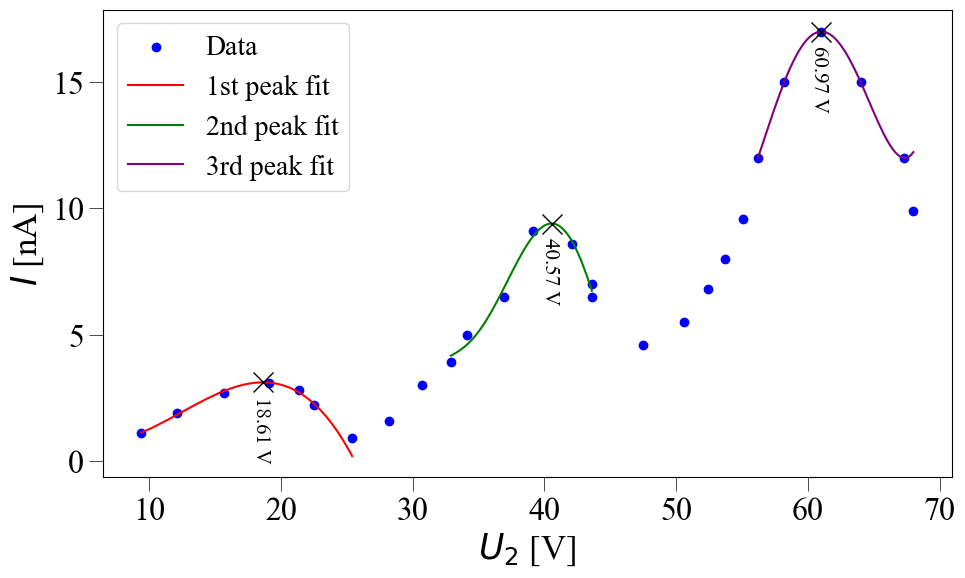

In [380]:
# Plot of VA

colors = ['#FF7F0E','#D62728','#FFDB58','#2CA02C','#17BECF','#1F77B4','#F0027F']  
plt.rc("font", size=10)
plt.rcParams["font.family"] = "Times New Roman"

# Define the font size
ax_l_size = 25
l_size = 23

fig, ax = plt.subplots(figsize=(10, 6))

# ax.title.set_fontsize(ax_l_size)
ax.set_xlabel(r"$U_2$ [V]")
ax.xaxis.label.set_fontsize(ax_l_size)
ax.set_ylabel(r"$I$ [nA]")
ax.yaxis.label.set_fontsize(ax_l_size)
ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=l_size)
ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=l_size)
# plt.xticks(rotation=45)
plt.tight_layout()  

ax.scatter(VA['U'], VA['I'], color='blue', label='Data')

ax.plot(x_val_1, fit_values_1, label='1st peak fit', color='red')
ax.plot(x_val_2, fit_values_2, label='2nd peak fit', color='green')
ax.plot(x_val_3, fit_values_3, label='3rd peak fit', color='purple')

ax.errorbar(peaks_df['U'].apply(lambda x: x.nominal_value), peaks_df['I'].apply(lambda x: x.nominal_value), xerr=peaks_df['U'].apply(lambda x: x.std_dev), yerr=peaks_df['I'].apply(lambda x: x.std_dev), fmt='x', markersize=15, color='black')

# for peak in peak_values_with_uncertainties:
#     ax.text(peak[0].nominal_value-0.8, peak[1].nominal_value-2.5, f"{peak[0].nominal_value:.2f} V", fontsize=15, rotation=-90)

for _, row in peaks_df.iterrows():
    u_nominal = row['U'].nominal_value
    i_nominal = row['I'].nominal_value
    ax.text(u_nominal - 0.9, i_nominal - 3, f"{u_nominal:.2f} V", fontsize=15, rotation=-90)

ax.legend(loc='upper left', fontsize=20)

plt.show() 

fig.savefig('images/peaks.png', bbox_inches='tight')

In [381]:
He

,lam,Sum,HeI,HeII
0,584.0,8.216000e-14,8.216000e-14,NaN
1,584.2,4.740000e-12,4.740000e-12,NaN
2,584.3,3.301000e-11,3.301000e-11,NaN
3,584.4,2.169000e-10,2.169000e-10,NaN
4,584.6,7.874000e-09,7.874000e-09,NaN
...,...,...,...,...
315,732.0,7.515000e-12,7.515000e-12,NaN
316,732.1,1.694000e-12,1.694000e-12,NaN
317,732.3,7.681000e-14,7.681000e-14,NaN
318,732.4,1.546000e-14,1.546000e-14,NaN


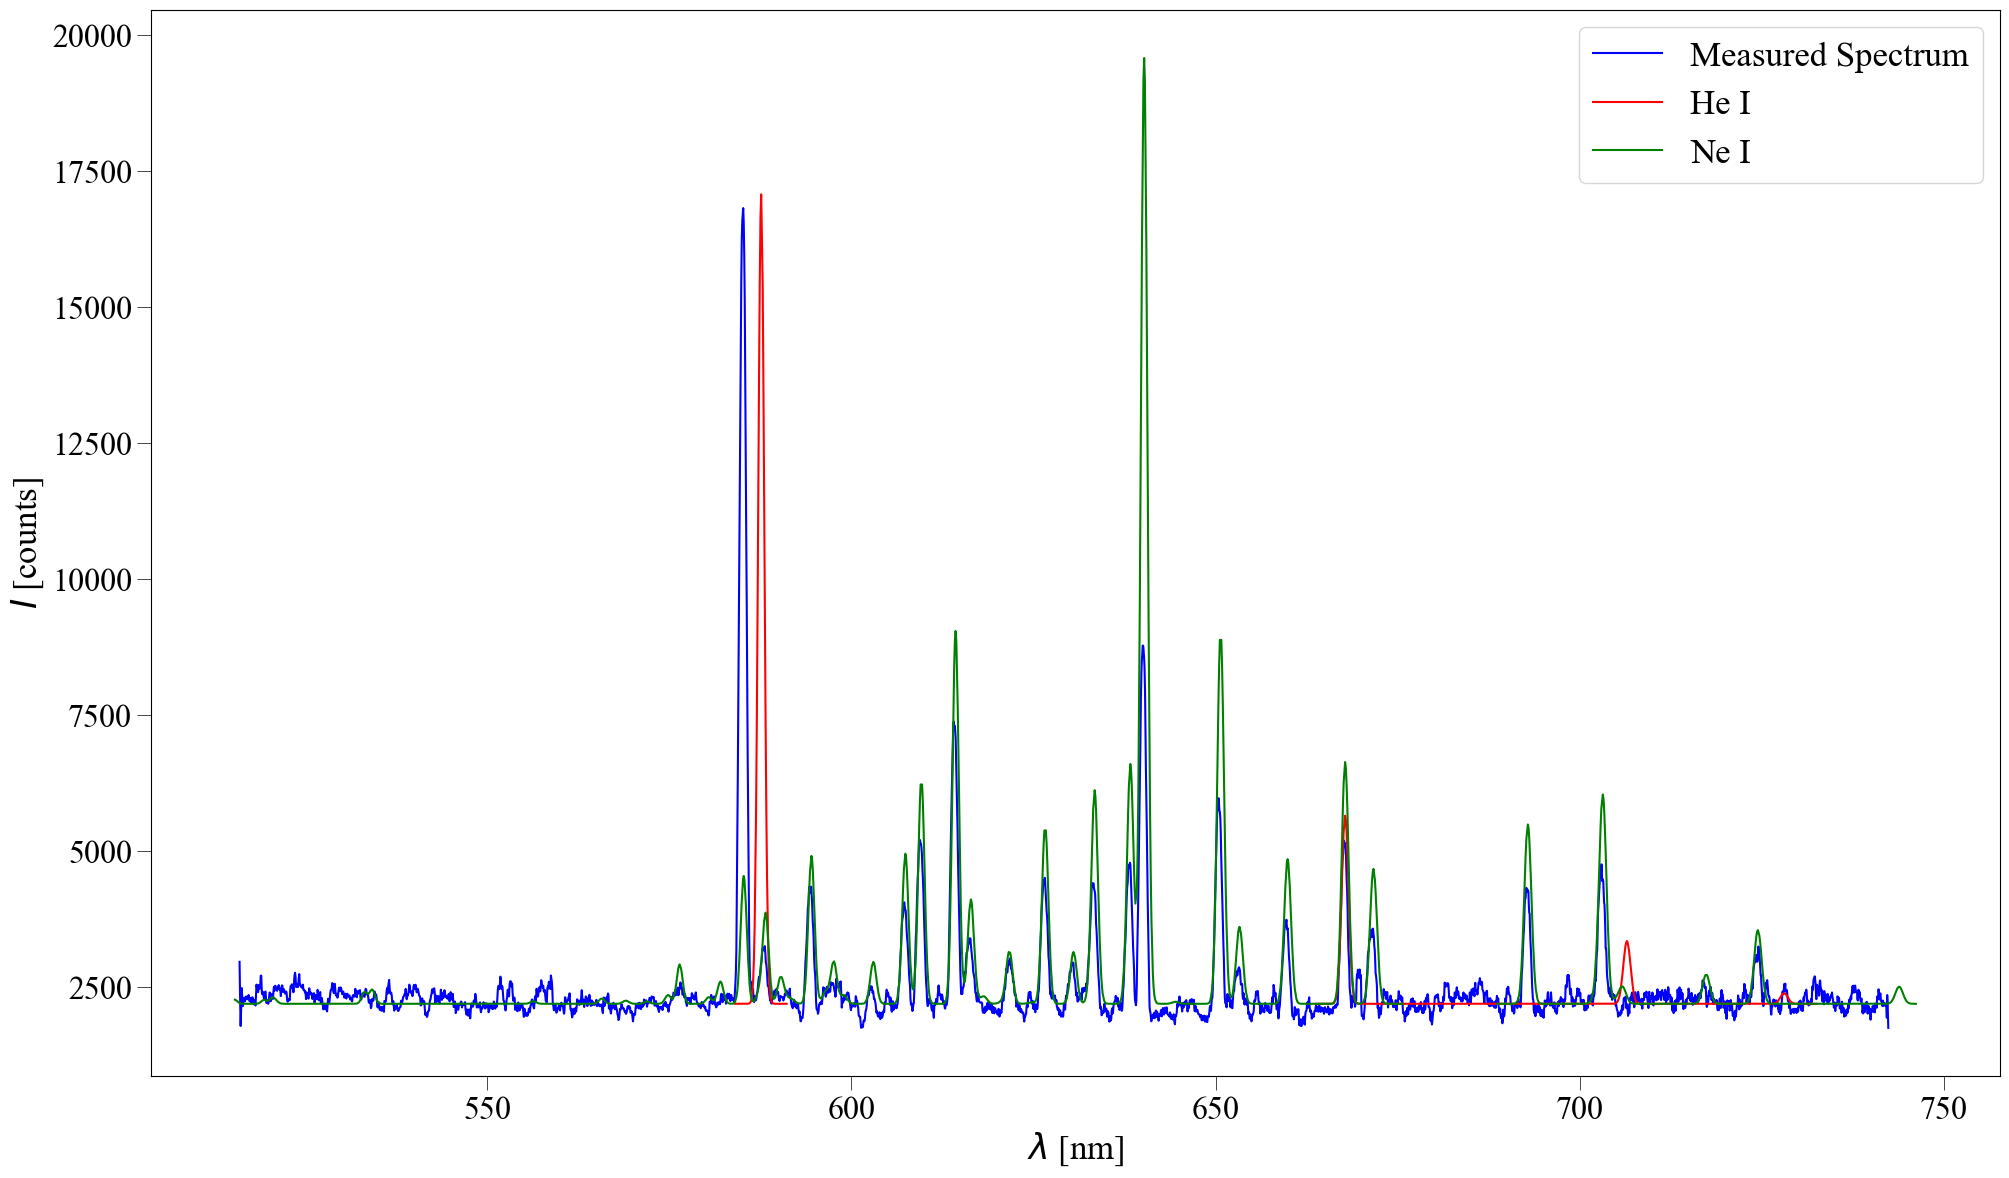

In [382]:
# Plot of spectrum

fig, ax = plt.subplots(figsize=(20, 12))

# ax.title.set_fontsize(ax_l_size)
ax.set_xlabel(r"$\lambda$ [nm]")
ax.xaxis.label.set_fontsize(ax_l_size)
ax.set_ylabel(r"$I$ [counts]")
ax.yaxis.label.set_fontsize(ax_l_size)
ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=l_size)
ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=l_size)
# plt.xticks(rotation=45)
plt.tight_layout()  
# ax.set_ylim(0, 60000)

ax.plot(spec['lam'], spec['int'], color='blue', label='Measured Spectrum')

ax.plot(He['lam'], He['HeI']*9 + 2200, color='red', label='He I')
ax.plot(Ne['lam'], Ne['NeI']*0.4 + 2200, color='green', label='Ne I')

ax.legend(loc='upper right', fontsize=25)

plt.show() 

fig.savefig('images/spec.png', bbox_inches='tight')

In [383]:
VA.to_csv('data/VA_proc.csv', index=False)